# Anomaly Detection using LSTM Encoder-Decoder.

This is the first of four notebooks used in defining and training an encoder-decoder LSTM architecture for anomaly detection. Each of the following four steps are completed in an individual notebook:

- __Preprocess__: Preprocess raw ICEWS data into time series for training and evaluating a model.
- __Train__: Create and train the model with pre-processed and cleaned data.
- __Threshold calculation__: Use the residuals from a validation set to determine an anomaly detection threshold.
- __Inference__: Run anomaly detection on data from various countries to assess performance.

## Load and aggregate global "stable" country data. 
Stable is our definition of normal for the purposes of this anomaly detection research. One easy way to show the model what stability means is to have it learn how to reconstruct time-series from a variety of stable countries. The country selection was based on the Fragile States Index (https://en.wikipedia.org/wiki/Fragile_States_Index).

In [1]:
import sys
sys.path.append('..')

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from util import data, preprocess, icews
from models.networks import train_encoder, LSTMEncoderDecoder
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

sns.set()
plt.rcParams['figure.figsize'] = (10, 5)
np.random.seed(111)

In [2]:
stable_countries = ['Poland', 'Czech Republic', 'Singapore', 'Spain',
                    'Greece', 'Belgium', 'Brazil', 'Germany',
                    'Canada', 'France', 'Japan', 'Australia',
                    'United States', 'United Kingdom']


global_df = pd.DataFrame()
for c in stable_countries:
    temp_df = icews.get_country_df(c, 'data/icews/')
    global_df = pd.concat([global_df, temp_df])
    
global_df.Country.value_counts()

loading data/icews/icews_poland_raw.parquet... done.
loading data/icews/icews_czech_republic_raw.parquet... done.
loading data/icews/icews_singapore_raw.parquet... done.
loading data/icews/icews_spain_raw.parquet... done.
loading data/icews/icews_greece_raw.parquet... done.
loading data/icews/icews_belgium_raw.parquet... done.
loading data/icews/icews_brazil_raw.parquet... done.
loading data/icews/icews_germany_raw.parquet... done.
loading data/icews/icews_canada_raw.parquet... done.
loading data/icews/icews_france_raw.parquet... done.
loading data/icews/icews_japan_raw.parquet... done.
loading data/icews/icews_australia_raw.parquet... done.
loading data/icews/icews_united_states_raw.parquet... done.
loading data/icews/icews_united_kingdom_raw.parquet... done.


United States     264040
United Kingdom    135189
Australia         127166
France             95886
Japan              95703
Germany            69848
Canada             56661
Belgium            54724
Brazil             54535
Greece             31634
Spain              24810
Czech Republic     20778
Poland             19422
Singapore          19180
Name: Country, dtype: int64

## Aggregation Method
The time series is multi-variate. Each Quad Class gets its own time series that is the rate of occurances of that quad class on that day. For example, on day $i$ the rate of for Quad Class 4 is calculated as:

$$
R^i_{QC4} = \frac{\text{# QC4 Occurances}}{\text{# Total Events}}
$$

In [3]:
global_ts = icews.run(global_df, ['QuadClass'])

## Visualize Global Timeseries Data for Stable Countries

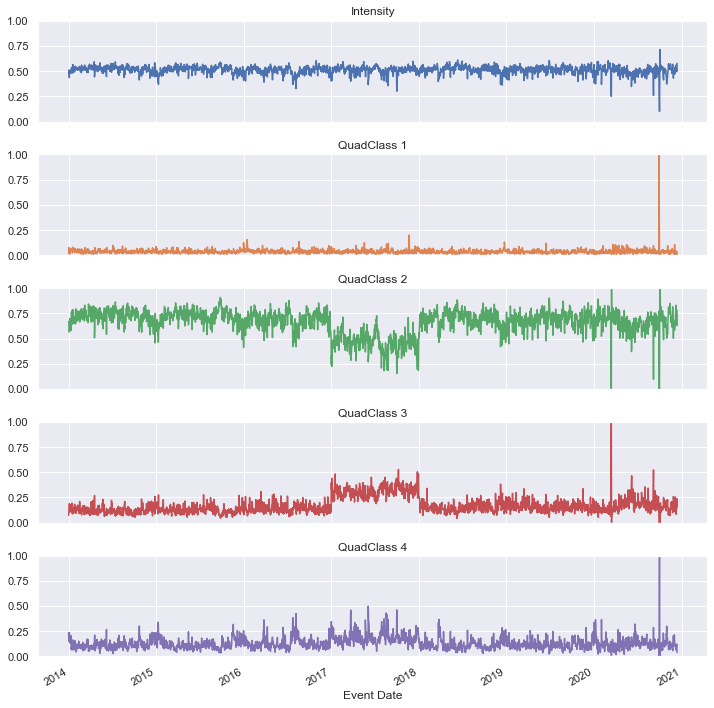

In [4]:
# Plot each timeseries in the data:
fig, axes = plt.subplots(5,1, figsize=(10, 10), sharex=True)
colors = plt.rcParams["axes.prop_cycle"]()

for col, ax in zip(global_ts, axes):
    c = next(colors)["color"]
    title = f"QuadClass {col}" if len(col) == 1 else col
    global_ts[col].plot(ax=ax, title=title, color=c)
    ax.set_ylim(0, 1)

plt.tight_layout();

It appears that there are outliers in this training data. It is worth considering cleaning them out in case they are anomalies. I'll replace any data points that are greater than 2 standard deviations with a random number pulled from the time series own distribution parameter estimates.

In [5]:
def replace_outliers(series, win_size=365, overlap=None):
    if overlap is None:
        overlap = win_size // 2
        
    mu = series.mean()
    sigma = series.std()
        
    step = win_size - overlap
    for i in range(0, len(series) - win_size + 1, step):
        
        # get window and its statistics
        window = series.iloc[i:i+win_size] # this might be view OR a copy... 
        w_mu = window.mean()
        w_sigma = window.std()
        
        # get indexes of outliers
        mask = np.abs(mu - window) <= 2 * sigma
        
        # replace global outliers with something from the window's distribution
        replace = np.random.default_rng().normal(w_mu, w_sigma, mask.shape)
        window = window.where(mask, other=replace)
        series.iloc[i:i+win_size] = window # in case pandas gave us a copy...
        
    return series

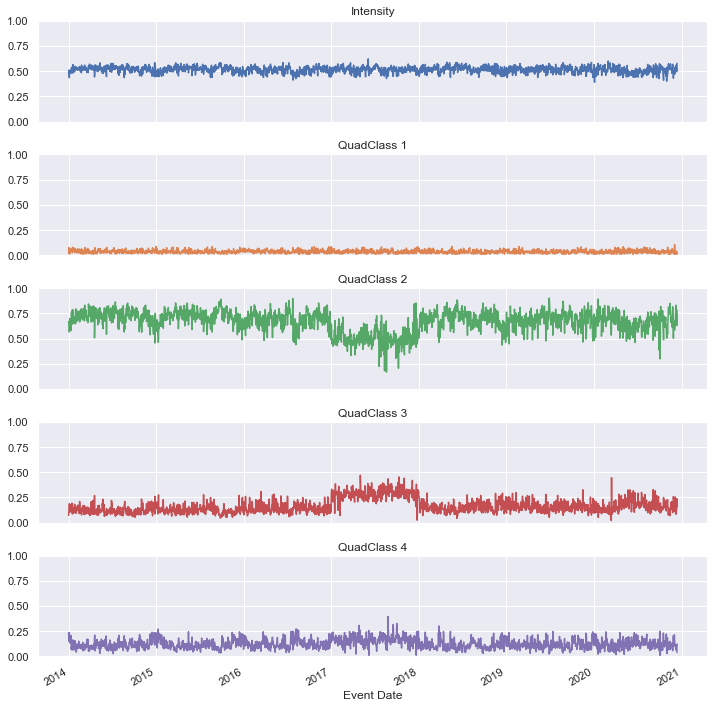

In [6]:
# Plot each timeseries in the data:
fig, axes = plt.subplots(5,1, figsize=(10, 10), sharex=True)
colors = plt.rcParams["axes.prop_cycle"]()
columns = global_ts.columns

global_ts = replace_outliers(global_ts, win_size=60, overlap=0)

for col, ax in zip(global_ts, axes):
    
    c = next(colors)["color"]
    title = f"QuadClass {col}" if len(col) == 1 else col
    global_ts[col].plot(ax=ax, title=title, color=c)
    ax.set_ylim(0, 1)

plt.tight_layout();

## Collect and divide data into 7-day subsquences
For each country, divide the data into 7 day subsequences, and add it to the training data. 

In [7]:
def sequence(a, window):
    """
    Divide time series data into an array of sub-sequences. 
    """
    if isinstance(a, (pd.Series, pd.DataFrame)):
        data = torch.tensor(a.copy().to_numpy()) 
    else: 
        raise TypeError(f"Data should be Pandas dataframe. Found {type(data)}.")
    
    rem = len(data) % window
    data = data[rem:]
    return torch.stack(torch.split(data, window)) 

In [8]:
# Define sub-sequence window size
window = 7

all_seqs = None
for c in stable_countries:
    # get specific country
    country_df = global_df[global_df.Country == c]
    
    # pre-process into time series aggregates
    country_ts = icews.run(country_df, ['QuadClass'])
    
    # squash outliers in timeseries
    country_ts = replace_outliers(country_ts)
    
    # split into 7-day sub sequences
    country_seqs = sequence(country_ts, window)
    
    # concatenate sequences to the data set
    if all_seqs is not None:
        all_seqs = np.concatenate((all_seqs, country_seqs))
    else: 
        all_seqs = country_seqs

In [9]:
all_seqs.shape

(4855, 7, 5)

## Split training data
Finally, split the data into training and validation sets. A difference transform is passed to the dataset objects. This transform helps detrend the data and forces the LSTM to learn underlying relationships rather than extrapolating.  (https://stackoverflow.com/a/65314347/3696204).

In [10]:
train_data, valid_data = train_test_split(all_seqs, test_size=0.2, shuffle=True)
train_data.shape, valid_data.shape

((3884, 7, 5), (971, 7, 5))

In [11]:
trfm = preprocess.Difference()
train_set = data.SimpleDataset(train_data, transform=trfm)
valid_set = data.SimpleDataset(valid_data, transform=trfm)

In [12]:
# save train and valid sets for later (training/scoring anomalies)
joblib.dump(train_set, f'data/icews_ml/{window}day_training.joblib')
joblib.dump(valid_set, f'data/icews_ml/{window}day_validate.joblib')

['data/icews_ml/7day_validate.joblib']